# Audible Insights: Intelligent Book Recommendations

## Understanding the Datasets

In [51]:
#import libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import umap.umap_ as umap
import pickle
import warnings

In [239]:
# Load the datasets
catalog_df = pd.read_csv('Audible_Catlog.csv')

catalog_adv_df = pd.read_csv('Audible_Catlog_Advanced_Features.csv')

In [5]:
catalog_df

,Book Name,Author,Rating,Number of Reviews,Price
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20174.0,10378.0
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4614.0,888.0
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4302.0,1005.0
...,...,...,...,...,...
6363,The Hot Flash Club,Nancy Thayer,4.3,191.0,1131.0
6364,The Prophet & The Wanderer,Khalil Gibran,4.1,6.0,539.0
6365,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,301.0,500.0
6366,25 Hours a Day: Going One More to Get What You...,Nick Bare,4.7,285.0,501.0


In [7]:
catalog_adv_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."
...,...,...,...,...,...,...,...,...
4459,"Factfulness: Wie wir lernen, die Welt so zu se...",Hans Rosling,4.6,72.0,703,"Sorry, we just need to make sure you're not a ...",-1,-1
4460,Late-Talking Children: A Symptom or a Stage?,Stephen M. Camarata,4.6,92.0,703,"Sorry, we just need to make sure you're not a ...",-1,-1
4461,"The Marketing of Evil: How Radicals, Elitists ...",David Kupelian,4.7,490.0,586,"Americans have come to tolerate, embrace, and ...",-1,-1
4462,Things I Wish I'd Known Before We Got Married,Gary Chapman,4.7,1388.0,516,\n\nOops!\nIt's rush hour and traffic is pilin...,-1,-1


In [9]:
catalog_df.info()
catalog_adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          6368 non-null   object 
 1   Author             6368 non-null   object 
 2   Rating             6368 non-null   float64
 3   Number of Reviews  5737 non-null   float64
 4   Price              6365 non-null   float64
dtypes: float64(3), object(2)
memory usage: 248.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          4464 non-null   object 
 1   Author             4464 non-null   object 
 2   Rating             4464 non-null   float64
 3   Number of Reviews  4043 non-null   float64
 4   Price              4464 non-null   int64  
 5   Description        4458 non-null   object 
 6   Listening

In [11]:
catalog_df.describe()

,Rating,Number of Reviews,Price
count,6368.000000,5737.000000,6365.000000
mean,3.913709,902.786822,923.212726
std,1.663320,2454.003227,1551.750993
min,-1.000000,1.000000,0.000000
25%,4.200000,64.000000,501.000000
50%,4.500000,231.000000,680.000000
75%,4.600000,746.000000,888.000000
max,5.000000,70077.000000,18290.000000


In [13]:
catalog_adv_df.describe()

,Rating,Number of Reviews,Price
count,4464.000000,4043.000000,4464.000000
mean,3.938866,1053.490725,942.052867
std,1.628824,2825.605319,1622.056490
min,-1.000000,1.000000,0.000000
25%,4.200000,71.000000,501.000000
50%,4.500000,263.000000,683.000000
75%,4.600000,893.500000,888.000000
max,5.000000,70122.000000,18290.000000


## Merge the Datasets

In [241]:
# Merge the two datasets on 'Book Name' and 'Author' using an inner join to keep only matching entries
merged_df = pd.merge(
    catalog_df,
    catalog_adv_df,
    on=["Book Name", "Author"],
    suffixes=('_basic', '_adv'),
    how='inner'
)

In [243]:
merged_df.shape

(4251, 11)

In [245]:
merged_df.head()

,Book Name,Author,Rating_basic,Number of Reviews_basic,Price_basic,Rating_adv,Number of Reviews_adv,Price_adv,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20174.0,10378.0,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4614.0,888.0,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4302.0,1005.0,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."


In [247]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Book Name                4251 non-null   object 
 1   Author                   4251 non-null   object 
 2   Rating_basic             4251 non-null   float64
 3   Number of Reviews_basic  3838 non-null   float64
 4   Price_basic              4249 non-null   float64
 5   Rating_adv               4251 non-null   float64
 6   Number of Reviews_adv    3839 non-null   float64
 7   Price_adv                4251 non-null   int64  
 8   Description              4245 non-null   object 
 9   Listening Time           4251 non-null   object 
 10  Ranks and Genre          4251 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 365.4+ KB


## Data Cleaning

In [249]:
# Remove redundant columns (keep '_adv' versions as they contain more features)
cleaned_df = merged_df.drop(columns=['Rating_basic', 'Number of Reviews_basic', 'Price_basic'])

In [251]:
# Rename the '_adv' columns to standard names
cleaned_df.rename(columns={
    'Rating_adv': 'Rating',
    'Number of Reviews_adv': 'Number of Reviews',
    'Price_adv': 'Price'
}, inplace=True)

In [253]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          4251 non-null   object 
 1   Author             4251 non-null   object 
 2   Rating             4251 non-null   float64
 3   Number of Reviews  3839 non-null   float64
 4   Price              4251 non-null   int64  
 5   Description        4245 non-null   object 
 6   Listening Time     4251 non-null   object 
 7   Ranks and Genre    4251 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 265.8+ KB


In [255]:
# Handle missing values
# Drop rows with missing Description 
cleaned_df.dropna(subset=['Description'], inplace=True)

In [257]:
# Fill missing values for Reviews
cleaned_df['Number of Reviews'].fillna(cleaned_df['Number of Reviews'].median(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\809553680.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['Number of Reviews'].fillna(cleaned_df['Number of Reviews'].median(), inplace=True)


In [259]:
cleaned_df.isnull().sum()

Book Name            0
Author               0
Rating               0
Number of Reviews    0
Price                0
Description          0
Listening Time       0
Ranks and Genre      0
dtype: int64

In [35]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4245 entries, 0 to 4250
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          4245 non-null   object 
 1   Author             4245 non-null   object 
 2   Rating             4245 non-null   float64
 3   Number of Reviews  4245 non-null   float64
 4   Price              4245 non-null   int64  
 5   Description        4245 non-null   object 
 6   Listening Time     4245 non-null   object 
 7   Ranks and Genre    4245 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 298.5+ KB


In [261]:
cleaned_df.to_csv('cleaned.csv')

In [263]:
def convert_listening_time(time_str):
    if not isinstance(time_str, str):
        return np.nan
    
    # Treat '-1' or similar invalid entries as missing
    if time_str.strip() == '-1':
        return np.nan

    # Normalize units
    time_str = time_str.lower().replace("hrs", "hours").replace("hr", "hour")
    time_str = time_str.replace("mins", "minutes").replace("min", "minute")

    # Initialize values
    hours = 0
    minutes = 0

    hour_match = re.search(r'(\d+)\s*hour', time_str)
    minute_match = re.search(r'(\d+)\s*minute', time_str)

    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))

    return hours * 60 + minutes

In [265]:
cleaned_df['Listening Time (mins)'] = cleaned_df['Listening Time'].apply(convert_listening_time)

In [267]:
cleaned_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre,Listening Time (mins)
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top...",654.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top...",203.0
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top...",317.0
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top...",335.0
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top...",385.0
...,...,...,...,...,...,...,...,...,...
4246,The Prophet & The Wanderer,Khalil Gibran,4.1,6.0,539,"Sorry, we just need to make sure you're not a ...",-1,-1,NaN
4247,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307.0,500,"Sorry, we just need to make sure you're not a ...",-1,-1,NaN
4248,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307.0,500,"Sorry, we just need to make sure you're not a ...",-1,-1,NaN
4249,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,-1.0,267.0,65,"Sorry, we just need to make sure you're not a ...",-1,-1,NaN


In [269]:
# Fill missing values for Listening Time (mins)
cleaned_df['Listening Time (mins)'].fillna(cleaned_df['Listening Time (mins)'].median(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\1556908334.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['Listening Time (mins)'].fillna(cleaned_df['Listening Time (mins)'].median(), inplace=True)


In [271]:
# Remove duplicates
cleaned_df.drop_duplicates(subset=['Book Name', 'Author'], inplace=True)

In [273]:
# drop unnecessary original columns
cleaned_df = cleaned_df.drop(columns=['Listening Time'])

In [275]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   float64
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Ranks and Genre        3346 non-null   object 
 7   Listening Time (mins)  3346 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 235.3+ KB


In [277]:
# Extraction: split 'Ranks and Genre' into 'Rank' and 'Genre'

def advanced_extract_rank(rank_genre_str):
    match = re.search(r'#(\d+)', rank_genre_str)
    return int(match.group(1)) if match else np.nan

In [279]:
# Refined genre extraction from varied formats
def advanced_extract_genre(rank_genre_str):
    # Try extracting genre after the last "in" and before "(" or end
    matches = re.findall(r'in\s+([^>#(]+)', rank_genre_str, re.IGNORECASE)
    if matches:
        return matches[-1].strip()
    # fallback: pick the last part after '>'
    parts = rank_genre_str.split('>')
    if parts:
        return parts[-1].strip()
    return np.nan

In [281]:
# Apply refined functions
cleaned_df['Rank'] = cleaned_df['Ranks and Genre'].apply(advanced_extract_rank)
cleaned_df['Genre'] = cleaned_df['Ranks and Genre'].apply(advanced_extract_genre)

In [283]:
cleaned_df['Rank'].unique()

array([  1.,   2.,   3.,   5.,   6.,   4.,   7.,   9.,   8.,  11.,  16.,
        10.,  18.,  13.,  15.,  12.,  17.,  14.,  21.,  19.,  23.,  22.,
        30.,  39.,  24.,  35.,  25.,  26.,  29.,  37.,  28.,  44.,  53.,
        34.,  31.,  36.,  40.,  20.,  nan,  55.,  27.,  38.,  47.,  33.,
        75.,  78.,  46., 116., 105.,  96.,  85.,  84., 135.,  98.,  80.,
       102.,  87.,  82.,  74.,  56., 130.,  77.,  79., 151.,  57., 114.,
       100., 112.,  83.,  88., 203.,  81.,  95., 104.,  94., 154., 133.,
        99.,  73., 220., 140., 131.,  93., 157., 122., 226.,  63., 296.,
       156., 187., 184., 139.,  97., 119., 126.,  89., 180., 193., 165.,
       103., 169., 143., 123., 167., 153., 120., 262.,  86., 275., 148.,
       150.,  90., 206., 209., 225., 127., 237., 559., 666., 115., 177.,
       162., 152., 137., 107., 110., 543., 293., 292., 537., 192., 141.,
       179., 175., 155., 160., 188., 780., 136.,  32., 444., 128., 183.,
       370., 207., 210., 290., 312., 170., 215., 27

In [285]:
cleaned_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Ranks and Genre,Listening Time (mins),Rank,Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",",#1 in Audible Audiobooks & Originals (See Top...",654.0,1.0,Society & Culture
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,",#2 in Audible Audiobooks & Originals (See Top...",203.0,2.0,Personal Success
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",",#3 in Audible Audiobooks & Originals (See Top...",317.0,3.0,Personal Development & Self-Help
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,",#5 in Audible Audiobooks & Originals (See Top...",335.0,5.0,Personal Success
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",",#6 in Audible Audiobooks & Originals (See Top...",385.0,6.0,Spiritualism
...,...,...,...,...,...,...,...,...,...,...
4228,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307.0,500,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,-1
4230,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,-1.0,267.0,65,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,-1
4232,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,-1.0,267.0,32,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,-1
4234,"Kill the Company: End the Status Quo, Start an...",Lisa Bodell,4.2,26.0,586,\n\nOops!\nIt's rush hour and traffic is pilin...,-1,485.5,NaN,-1


In [287]:
# Pattern to identify and remove junk genre entries (e.g., %, star ratings, empty segments, stray punctuation)
junk_pattern = re.compile(r'^\s*[,0-9%\s\(\)star]+$|^\s*[-1]+$|^,.*%.*,$|^,.*star.*,$|^,.*$')

In [289]:
# Function to clean Genre values
def clean_genre(value):
    if pd.isna(value):
        return None
    value = value.strip()
    if junk_pattern.match(value):
        return None
    # Fix spacing, remove repeated commas
    value = re.sub(r'\s*,\s*', ', ', value)
    value = re.sub(r'\s+', ' ', value)
    value = value.strip(', ')
    return value

In [291]:
# Apply cleaning function
cleaned_df['Genre'] = cleaned_df['Genre'].apply(clean_genre)

In [293]:
cleaned_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Ranks and Genre,Listening Time (mins),Rank,Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",",#1 in Audible Audiobooks & Originals (See Top...",654.0,1.0,Society & Culture
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,",#2 in Audible Audiobooks & Originals (See Top...",203.0,2.0,Personal Success
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",",#3 in Audible Audiobooks & Originals (See Top...",317.0,3.0,Personal Development & Self-Help
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,",#5 in Audible Audiobooks & Originals (See Top...",335.0,5.0,Personal Success
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",",#6 in Audible Audiobooks & Originals (See Top...",385.0,6.0,Spiritualism
...,...,...,...,...,...,...,...,...,...,...
4228,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307.0,500,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,None
4230,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,-1.0,267.0,65,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,None
4232,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,-1.0,267.0,32,"Sorry, we just need to make sure you're not a ...",-1,485.5,NaN,None
4234,"Kill the Company: End the Status Quo, Start an...",Lisa Bodell,4.2,26.0,586,\n\nOops!\nIt's rush hour and traffic is pilin...,-1,485.5,NaN,None


In [295]:
cleaned_df['Genre'].unique()

array(['Society & Culture', 'Personal Success',
       'Personal Development & Self-Help', 'Spiritualism',
       'Business Careers', 'Anthropology', 'Analysis & Strategy',
       'Healthy Living & Wellness', 'Business Management',
       'Earth Sciences Books', 'Fantasy', 'Crime, Thriller & Mystery',
       'Biographies & Autobiographies', 'Biographies of Actors',
       'Personal Finance', 'Political Theory', 'Investing & Trading',
       'Biographies of Business Leaders', 'Spirituality',
       'Mind, Body & Spirit', 'Organisational Behaviour',
       'Theology & Philosophy of Religion',
       'Fiction on Friendship for Children',
       'Forecasting & Strategic Planning', 'Entrepreneurship',
       'Time Management & Productivity', 'Christianity', 'Essays', None,
       'Sociology', 'Fairy Tale Collections & Anthologies for Children',
       'Economics Books', 'History', 'Colonialism & Post-Colonialism',
       'Fiction on Orphans & Foster Homes for Children',
       'English Lang

In [297]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   float64
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Ranks and Genre        3346 non-null   object 
 7   Listening Time (mins)  3346 non-null   float64
 8   Rank                   1778 non-null   float64
 9   Genre                  1778 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 287.5+ KB


In [299]:
# Create a subset with known genres and descriptions
known_genres = cleaned_df[cleaned_df['Genre'].notnull()]
unknown_genres = cleaned_df[cleaned_df['Genre'].isnull()]

In [301]:
# Vectorize descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_known = vectorizer.fit_transform(known_genres['Description'])
tfidf_unknown = vectorizer.transform(unknown_genres['Description'])

In [303]:
# Use Nearest Neighbors to find closest match by description
nn = NearestNeighbors(n_neighbors=1, metric='cosine')
nn.fit(tfidf_known)

NearestNeighbors(metric='cosine', n_neighbors=1)

In [305]:
# Predict genres for missing entries
distances, indices = nn.kneighbors(tfidf_unknown)
predicted_genres = known_genres.iloc[indices.flatten()]['Genre'].values

In [307]:
# Fill in the predicted genres
cleaned_df.loc[cleaned_df['Genre'].isnull(), 'Genre'] = predicted_genres

In [309]:
# Check genre
filled_genre_counts = cleaned_df['Genre'].value_counts().head(10)
cleaned_df[['Book Name', 'Genre']].head(), filled_genre_counts

(                                           Book Name  \
 0  Think Like a Monk: The Secret of How to Harnes...   
 1  Ikigai: The Japanese Secret to a Long and Happ...   
 2  The Subtle Art of Not Giving a F*ck: A Counter...   
 3  Atomic Habits: An Easy and Proven Way to Build...   
 4  Life's Amazing Secrets: How to Find Balance an...   
 
                               Genre  
 0                 Society & Culture  
 1                  Personal Success  
 2  Personal Development & Self-Help  
 3                  Personal Success  
 4                      Spiritualism  ,
 Genre
 Theology & Philosophy of Religion    757
 Fantasy                              445
 Personal Development & Self-Help     159
 Textbooks & Study Guides             112
 Analysis & Strategy                   93
 Personal Success                      69
 Biographies & Autobiographies         67
 Contemporary Fiction                  54
 Romance                               48
 Crime, Thriller & Mystery          

In [311]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   float64
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Ranks and Genre        3346 non-null   object 
 7   Listening Time (mins)  3346 non-null   float64
 8   Rank                   1778 non-null   float64
 9   Genre                  3346 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 287.5+ KB


In [313]:
# Fill missing values for Rank
cleaned_df['Rank'].fillna(cleaned_df['Rank'].median(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\222559115.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['Rank'].fillna(cleaned_df['Rank'].median(), inplace=True)


In [315]:
# Convert 'Number of Reviews' and 'Rank' to integer type
cleaned_df['Number of Reviews'] = cleaned_df['Number of Reviews'].astype(int)
cleaned_df['Rank'] = cleaned_df['Rank'].astype(int)

In [317]:
# drop unnecessary original columns
cleaned_df = cleaned_df.drop(columns=['Ranks and Genre'])

In [319]:
cleaned_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (mins),Rank,Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371,10080,"Over the past three years, Jay Shetty has beco...",654.0,1,Society & Culture
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682,615,Brought to you by Penguin.,203.0,2,Personal Success
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306,10378,"In this generation-defining self-help guide, a...",317.0,3,Personal Development & Self-Help
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678,888,Brought to you by Penguin.,335.0,5,Personal Success
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308,1005,"Stop going through life, Start growing throug...",385.0,6,Spiritualism
...,...,...,...,...,...,...,...,...,...
4228,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307,500,"Sorry, we just need to make sure you're not a ...",485.5,3,Theology & Philosophy of Religion
4230,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,-1.0,267,65,"Sorry, we just need to make sure you're not a ...",485.5,3,Theology & Philosophy of Religion
4232,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,-1.0,267,32,"Sorry, we just need to make sure you're not a ...",485.5,3,Theology & Philosophy of Religion
4234,"Kill the Company: End the Status Quo, Start an...",Lisa Bodell,4.2,26,586,\n\nOops!\nIt's rush hour and traffic is pilin...,485.5,3,Fantasy


In [321]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   int32  
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Listening Time (mins)  3346 non-null   float64
 7   Rank                   3346 non-null   int32  
 8   Genre                  3346 non-null   object 
dtypes: float64(2), int32(2), int64(1), object(4)
memory usage: 235.3+ KB


In [323]:
cleaned_df.isnull().sum()

Book Name                0
Author                   0
Rating                   0
Number of Reviews        0
Price                    0
Description              0
Listening Time (mins)    0
Rank                     0
Genre                    0
dtype: int64

In [325]:
cleaned_df['Rating']

0       4.9
1       4.6
2       4.4
3       4.6
4       4.6
       ... 
4228    4.7
4230   -1.0
4232   -1.0
4234    4.2
4235    4.6
Name: Rating, Length: 3346, dtype: float64

In [327]:
cleaned_df["Rating"].replace(-1.0, np.nan, inplace=True)

In [329]:
cleaned_df['Rating'].isnull().sum()

319

In [331]:
cleaned_df["Rating"].fillna(cleaned_df["Rating"].median(), inplace=True)

In [333]:
cleaned_df = cleaned_df[(cleaned_df["Rating"] >= 0) & (cleaned_df["Rating"] <= 5)]

In [335]:
cleaned_df['Rating'].unique()

array([4.9, 4.6, 4.4, 4.1, 4.5, 3.6, 5. , 4. , 4.2, 4.8, 4.7, 3.4, 3.9,
       4.3, 3. , 3.8, 2.5, 2. , 3.5, 2.4, 1. , 3.1, 3.2, 3.7, 3.3, 1.9,
       2.6, 2.7, 2.9])

In [337]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   int32  
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Listening Time (mins)  3346 non-null   float64
 7   Rank                   3346 non-null   int32  
 8   Genre                  3346 non-null   object 
dtypes: float64(2), int32(2), int64(1), object(4)
memory usage: 235.3+ KB


In [339]:
cleaned_df.to_csv('cleaned_book_data.csv',index=False)

## EDA

In [5]:
# Read the dataset
df = pd.read_csv('cleaned_book_data.csv')

In [343]:
print("\n" + "="*60)
print("EASY LEVEL QUESTIONS")
print("="*60)

# Question 1: Most popular genres
print("\n1. MOST POPULAR GENRES")
print("-" * 30)
genre_counts = df['Genre'].value_counts()
top_10_genres = genre_counts.head(10)
print("Top 10 Most Popular Genres:")
for i, (genre, count) in enumerate(top_10_genres.items(), 1):
    print(f"{i:2d}. {genre}: {count} books")


EASY LEVEL QUESTIONS

1. MOST POPULAR GENRES
------------------------------
Top 10 Most Popular Genres:
 1. Theology & Philosophy of Religion: 757 books
 2. Fantasy: 445 books
 3. Personal Development & Self-Help: 159 books
 4. Textbooks & Study Guides: 112 books
 5. Analysis & Strategy: 93 books
 6. Personal Success: 69 books
 7. Biographies & Autobiographies: 67 books
 8. Contemporary Fiction: 54 books
 9. Romance: 48 books
10. Crime, Thriller & Mystery: 44 books


In [345]:
# Question 2: Authors with highest-rated books
print("\n2. AUTHORS WITH HIGHEST-RATED BOOKS")
print("-" * 40)
# Get authors with at least 2 books for meaningful comparison
author_stats = df.groupby('Author').agg({
    'Rating': ['mean', 'count'],
    'Number of Reviews': 'sum'
}).round(2)
author_stats.columns = ['Avg_Rating', 'Book_Count', 'Total_Reviews']
author_stats = author_stats[author_stats['Book_Count'] >= 2]  # Authors with 2+ books
top_rated_authors = author_stats.sort_values('Avg_Rating', ascending=False).head(10)

print("Top 10 Highest-Rated Authors (with 2+ books):")
for i, (author, stats) in enumerate(top_rated_authors.iterrows(), 1):
    print(f"{i:2d}. {author}: {stats['Avg_Rating']:.2f} avg rating ({stats['Book_Count']} books)")


2. AUTHORS WITH HIGHEST-RATED BOOKS
----------------------------------------
Top 10 Highest-Rated Authors (with 2+ books):
 1. Vikram Sampath: 4.90 avg rating (2.0 books)
 2. John Ramirez: 4.85 avg rating (2.0 books)
 3. Timothy Zahn: 4.85 avg rating (2.0 books)
 4. Kate DiCamillo: 4.80 avg rating (2.0 books)
 5. Joel Osteen: 4.80 avg rating (2.0 books)
 6. Watchman Nee: 4.80 avg rating (2.0 books)
 7. E.J. Noyes: 4.80 avg rating (2.0 books)
 8. Michel Danino: 4.80 avg rating (2.0 books)
 9. J. Krishnamurti: 4.80 avg rating (3.0 books)
10. Isabel Wilkerson: 4.80 avg rating (2.0 books)


In [347]:
# Question 3: Average rating distribution
print("\n3. AVERAGE RATING DISTRIBUTION")
print("-" * 35)
rating_dist = df['Rating'].value_counts().sort_index()
print("Rating distribution:")
for rating, count in rating_dist.items():
    percentage = (count / len(df)) * 100
    print(f"Rating {rating}: {count} books ({percentage:.1f}%)")

print(f"\nOverall statistics:")
print(f"Mean rating: {df['Rating'].mean():.2f}")
print(f"Median rating: {df['Rating'].median():.2f}")
print(f"Standard deviation: {df['Rating'].std():.2f}")


3. AVERAGE RATING DISTRIBUTION
-----------------------------------
Rating distribution:
Rating 1.0: 6 books (0.2%)
Rating 1.9: 1 books (0.0%)
Rating 2.0: 2 books (0.1%)
Rating 2.4: 2 books (0.1%)
Rating 2.5: 4 books (0.1%)
Rating 2.6: 3 books (0.1%)
Rating 2.7: 2 books (0.1%)
Rating 2.9: 2 books (0.1%)
Rating 3.0: 10 books (0.3%)
Rating 3.1: 4 books (0.1%)
Rating 3.2: 4 books (0.1%)
Rating 3.3: 4 books (0.1%)
Rating 3.4: 12 books (0.4%)
Rating 3.5: 10 books (0.3%)
Rating 3.6: 14 books (0.4%)
Rating 3.7: 22 books (0.7%)
Rating 3.8: 20 books (0.6%)
Rating 3.9: 41 books (1.2%)
Rating 4.0: 79 books (2.4%)
Rating 4.1: 108 books (3.2%)
Rating 4.2: 175 books (5.2%)
Rating 4.3: 267 books (8.0%)
Rating 4.4: 390 books (11.7%)
Rating 4.5: 823 books (24.6%)
Rating 4.6: 567 books (16.9%)
Rating 4.7: 475 books (14.2%)
Rating 4.8: 195 books (5.8%)
Rating 4.9: 33 books (1.0%)
Rating 5.0: 71 books (2.1%)

Overall statistics:
Mean rating: 4.46
Median rating: 4.50
Standard deviation: 0.34


In [349]:
# Question 4: Ratings vs Review counts
print("\n4. RATINGS VS REVIEW COUNTS ANALYSIS")
print("-" * 40)
# Create review count categories
df['Review_Category'] = pd.cut(df['Number of Reviews'], 
                              bins=[0, 100, 1000, 5000, float('inf')], 
                              labels=['Low (1-100)', 'Medium (101-1000)', 
                                     'High (1001-5000)', 'Very High (5000+)'])

rating_by_reviews = df.groupby('Review_Category')['Rating'].agg(['mean', 'count']).round(2)
print("Average rating by review count category:")
for category, stats in rating_by_reviews.iterrows():
    print(f"{category}: {stats['mean']:.2f} avg rating ({stats['count']} books)")


4. RATINGS VS REVIEW COUNTS ANALYSIS
----------------------------------------
Average rating by review count category:
Low (1-100): 4.32 avg rating (886.0 books)
Medium (101-1000): 4.49 avg rating (1717.0 books)
High (1001-5000): 4.54 avg rating (587.0 books)
Very High (5000+): 4.53 avg rating (156.0 books)


C:\Users\DELL\AppData\Local\Temp\ipykernel_4576\4020002595.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_by_reviews = df.groupby('Review_Category')['Rating'].agg(['mean', 'count']).round(2)


In [351]:
print("\n" + "="*60)
print("MEDIUM LEVEL ANALYSIS")
print("="*60)

# Medium Level Analysis
print("\n1. GENRE SIMILARITY ANALYSIS")
print("-" * 35)
# Find books that share similar genre keywords
genre_keywords = {}
for genre in df['Genre'].unique():
    words = genre.lower().split()
    for word in words:
        if word not in ['&', 'for', 'and', 'of', 'the', 'in', 'on']:
            if word not in genre_keywords:
                genre_keywords[word] = []
            genre_keywords[word].append(genre)

# Find most common genre keywords
keyword_counts = {k: len(v) for k, v in genre_keywords.items()}
top_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most common genre keywords:")
for i, (keyword, count) in enumerate(top_keywords, 1):
    print(f"{i:2d}. '{keyword}': appears in {count} different genres")


MEDIUM LEVEL ANALYSIS

1. GENRE SIMILARITY ANALYSIS
-----------------------------------
Most common genre keywords:
 1. 'fiction': appears in 44 different genres
 2. 'children': appears in 25 different genres
 3. 'history': appears in 19 different genres
 4. 'business': appears in 13 different genres
 5. 'biographies': appears in 13 different genres
 6. 'science': appears in 13 different genres
 7. 'children's': appears in 12 different genres
 8. 'teens': appears in 11 different genres
 9. 'fantasy': appears in 10 different genres
10. 'philosophy': appears in 10 different genres


In [353]:
print("\n2. AUTHOR POPULARITY EFFECT ON RATINGS")
print("-" * 45)
# Analyze if authors with more books have different rating patterns
df['Author_Book_Count'] = df.groupby('Author')['Book Name'].transform('count')
author_popularity_analysis = df.groupby('Author_Book_Count')['Rating'].agg(['mean', 'count']).round(2)
author_popularity_analysis = author_popularity_analysis[author_popularity_analysis['count'] >= 10]
print("Rating patterns by author productivity (authors with 10+ total books in dataset):")
for book_count, stats in author_popularity_analysis.iterrows():
    print(f"Authors with {book_count} books: {stats['mean']:.2f} avg rating ({stats['count']} total books)")


2. AUTHOR POPULARITY EFFECT ON RATINGS
---------------------------------------------
Rating patterns by author productivity (authors with 10+ total books in dataset):
Authors with 1 books: 4.45 avg rating (1872.0 total books)
Authors with 2 books: 4.48 avg rating (478.0 total books)
Authors with 3 books: 4.47 avg rating (240.0 total books)
Authors with 4 books: 4.44 avg rating (168.0 total books)
Authors with 5 books: 4.43 avg rating (100.0 total books)
Authors with 6 books: 4.52 avg rating (72.0 total books)
Authors with 7 books: 4.47 avg rating (49.0 total books)
Authors with 8 books: 4.52 avg rating (56.0 total books)
Authors with 9 books: 4.48 avg rating (54.0 total books)
Authors with 10 books: 4.43 avg rating (30.0 total books)
Authors with 11 books: 4.53 avg rating (22.0 total books)
Authors with 12 books: 4.55 avg rating (12.0 total books)
Authors with 14 books: 4.55 avg rating (28.0 total books)
Authors with 15 books: 4.22 avg rating (45.0 total books)
Authors with 17 books: 

In [355]:
print("\n3. FEATURE CORRELATION ANALYSIS")
print("-" * 35)
# Correlation between numerical features
numerical_cols = ['Rating', 'Number of Reviews', 'Price', 'Listening Time (mins)', 'Rank']
correlation_matrix = df[numerical_cols].corr().round(3)
print("Correlation matrix between numerical features:")
print(correlation_matrix)


3. FEATURE CORRELATION ANALYSIS
-----------------------------------
Correlation matrix between numerical features:
                       Rating  Number of Reviews  Price  \
Rating                  1.000              0.061  0.029   
Number of Reviews       0.061              1.000  0.090   
Price                   0.029              0.090  1.000   
Listening Time (mins)   0.028              0.066  0.112   
Rank                    0.022              0.045  0.021   

                       Listening Time (mins)   Rank  
Rating                                 0.028  0.022  
Number of Reviews                      0.066  0.045  
Price                                  0.112  0.021  
Listening Time (mins)                  1.000  0.119  
Rank                                   0.119  1.000  


In [357]:
print("\n" + "="*60)
print("SCENARIO-BASED RECOMMENDATIONS")
print("="*60)

# Scenario 1: Science fiction recommendations
print("\n1. TOP 5 SCIENCE FICTION BOOK RECOMMENDATIONS")
print("-" * 50)
sci_fi_books = df[df['Genre'].str.contains('Science Fiction', case=False, na=False)]
top_sci_fi = sci_fi_books.nlargest(5, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews']]
print("Recommended Science Fiction books:")
for i, (_, book) in enumerate(top_sci_fi.iterrows(), 1):
    print(f"{i}. '{book['Book Name']}' by {book['Author']}")
    print(f"   Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}")


SCENARIO-BASED RECOMMENDATIONS

1. TOP 5 SCIENCE FICTION BOOK RECOMMENDATIONS
--------------------------------------------------
Recommended Science Fiction books:
1. 'So Long, Lollipops: The Free Until The End of the World Novella' by Sarah Lyons Fleming
   Rating: 4.8, Reviews: 174
2. 'Morning Star: Book III of the Red Rising Trilogy' by Pierce Brown
   Rating: 4.8, Reviews: 3016
3. 'Jurassic Park: A Novel' by Michael Crichton
   Rating: 4.7, Reviews: 3259
4. 'Thrawn (Star Wars)' by Timothy Zahn
   Rating: 4.7, Reviews: 2328
5. 'Gemina: The Illuminae Files, Book 2' by Amie Kaufman
   Rating: 4.7, Reviews: 523


In [359]:
# Scenario 2: Thriller recommendations
print("\n2. THRILLER RECOMMENDATIONS")
print("-" * 30)
thriller_books = df[df['Genre'].str.contains('Thriller|Mystery|Crime', case=False, na=False)]
top_thrillers = thriller_books.nlargest(5, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews']]
print("Recommended Thriller/Mystery books:")
for i, (_, book) in enumerate(top_thrillers.iterrows(), 1):
    print(f"{i}. '{book['Book Name']}' by {book['Author']}")
    print(f"   Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}")


2. THRILLER RECOMMENDATIONS
------------------------------
Recommended Thriller/Mystery books:
1. 'Sherlock Holmes: The Definitive Collection' by Arthur Conan Doyle
   Rating: 5.0, Reviews: 6
2. 'Blasphemy: The Trial of Danesh Masih' by Osman Haneef
   Rating: 4.9, Reviews: 13
3. 'Hunting November' by Adriana Mather
   Rating: 4.8, Reviews: 89
4. 'Crystal Muse: Everyday Rituals to Tune In to the Real You' by Heather Askinosie
   Rating: 4.8, Reviews: 762
5. 'The Da Vinci Code' by Dan Brown
   Rating: 4.7, Reviews: 3836


In [361]:
# Scenario 3: Hidden gems (high rating, low popularity)
print("\n3. HIDDEN GEMS (High Rating, Low Popularity)")
print("-" * 50)
# Define hidden gems as books with rating >= 4.5 and reviews < 500
hidden_gems = df[(df['Rating'] >= 4.5) & (df['Number of Reviews'] < 500)]
hidden_gems_sorted = hidden_gems.nlargest(10, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews', 'Genre']]
print("Top 10 Hidden Gems:")
for i, (_, book) in enumerate(hidden_gems_sorted.iterrows(), 1):
    print(f"{i:2d}. '{book['Book Name']}' by {book['Author']}")
    print(f"    Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}, Genre: {book['Genre']}")


3. HIDDEN GEMS (High Rating, Low Popularity)
--------------------------------------------------
Top 10 Hidden Gems:
 1. 'The Sandman' by Neil Gaiman
    Rating: 5.0, Reviews: 1, Genre: Fantasy
 2. 'Sherlock Holmes: The Definitive Collection' by Arthur Conan Doyle
    Rating: 5.0, Reviews: 6, Genre: Crime, Thriller & Mystery
 3. 'F*cking History: 111 Lessons You Should Have Learned in School' by The Captain
    Rating: 5.0, Reviews: 185, Genre: Family & Relationships
 4. 'No Calculator? No Problem!: Mastering Mental Math' by Art Benjamin
    Rating: 5.0, Reviews: 1, Genre: Education
 5. 'Satyajit Ray Ki Kahaniyan [Stories of Satyajit Ray]' by Satyajit Rai
    Rating: 5.0, Reviews: 1, Genre: Short Stories
 6. 'The Ultimate Jim Rohn Library' by Jim Rohn
    Rating: 5.0, Reviews: 1, Genre: Personal Development & Self-Help
 7. '50 Self-Help Classics to Guide You to Financial Freedom' by Napoleon Hill
    Rating: 5.0, Reviews: 1, Genre: Personal Development & Self-Help
 8. 'Learn Spanish wi

In [363]:
print("\n" + "="*60)
print("ADDITIONAL INSIGHTS")
print("="*60)

# Price analysis
print("\n1. PRICE ANALYSIS")
print("-" * 20)
# Remove books with price = 0 (likely free/promotional)
paid_books = df[df['Price'] > 0]
price_rating_corr = paid_books[['Price', 'Rating']].corr().iloc[0, 1]
print(f"Correlation between price and rating: {price_rating_corr:.3f}")
print(f"Average price of books: ${paid_books['Price'].mean():.2f}")
print(f"Price range: ${paid_books['Price'].min()} - ${paid_books['Price'].max()}")


ADDITIONAL INSIGHTS

1. PRICE ANALYSIS
--------------------
Correlation between price and rating: 0.020
Average price of books: $991.47
Price range: $23 - $18290


In [365]:
# Listening time analysis
print("\n2. LISTENING TIME ANALYSIS")
print("-" * 30)
listening_time_stats = df['Listening Time (mins)'].describe()
print("Listening time statistics (minutes):")
print(f"Average: {listening_time_stats['mean']:.0f} minutes ({listening_time_stats['mean']/60:.1f} hours)")
print(f"Range: {listening_time_stats['min']:.0f} - {listening_time_stats['max']:.0f} minutes")


2. LISTENING TIME ANALYSIS
------------------------------
Listening time statistics (minutes):
Average: 547 minutes (9.1 hours)
Range: 0 - 6139 minutes


In [367]:
# Genre diversity by top authors
print("\n3. AUTHOR GENRE DIVERSITY")
print("-" * 30)
author_genre_diversity = df.groupby('Author')['Genre'].nunique().sort_values(ascending=False)
diverse_authors = author_genre_diversity[author_genre_diversity > 1].head(10)
print("Most genre-diverse authors:")
for i, (author, genre_count) in enumerate(diverse_authors.items(), 1):
    book_count = df[df['Author'] == author].shape[0]
    print(f"{i:2d}. {author}: {genre_count} different genres ({book_count} books)")


3. AUTHOR GENRE DIVERSITY
------------------------------
Most genre-diverse authors:
 1. Harvard Business Review: 15 different genres (24 books)
 2. Devdutt Pattanaik: 15 different genres (23 books)
 3. Roald Dahl: 10 different genres (14 books)
 4. Brian Tracy: 9 different genres (14 books)
 5. Thich Nhat Hanh: 8 different genres (9 books)
 6. Robin Sharma: 8 different genres (17 books)
 7. Rick Riordan: 8 different genres (22 books)
 8. Innovative Language Learning: 8 different genres (17 books)
 9. Agatha Christie: 8 different genres (12 books)
10. Chetan Bhagat: 7 different genres (8 books)


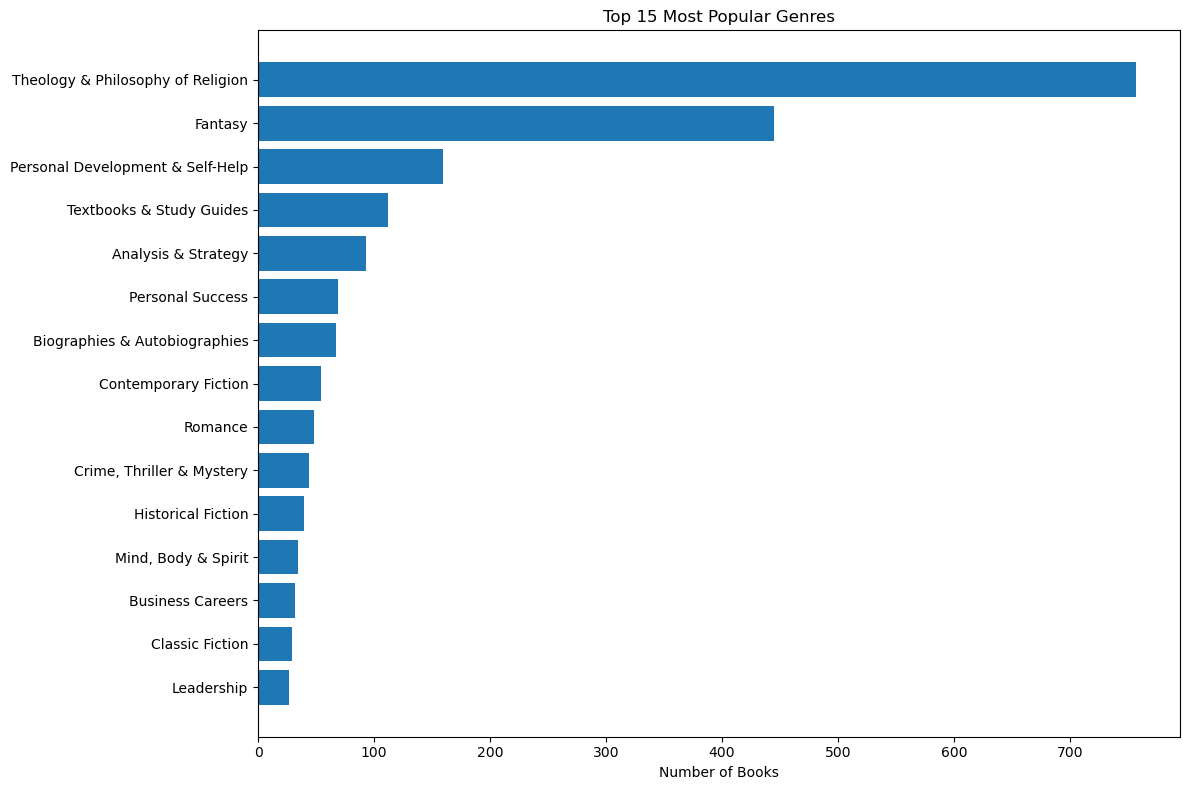

In [369]:
# Popular genres
plt.figure(figsize=(12, 8))
top_15_genres = df['Genre'].value_counts().head(15)
plt.barh(range(len(top_15_genres)), top_15_genres.values)
plt.yticks(range(len(top_15_genres)), top_15_genres.index)
plt.xlabel('Number of Books')
plt.title('Top 15 Most Popular Genres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

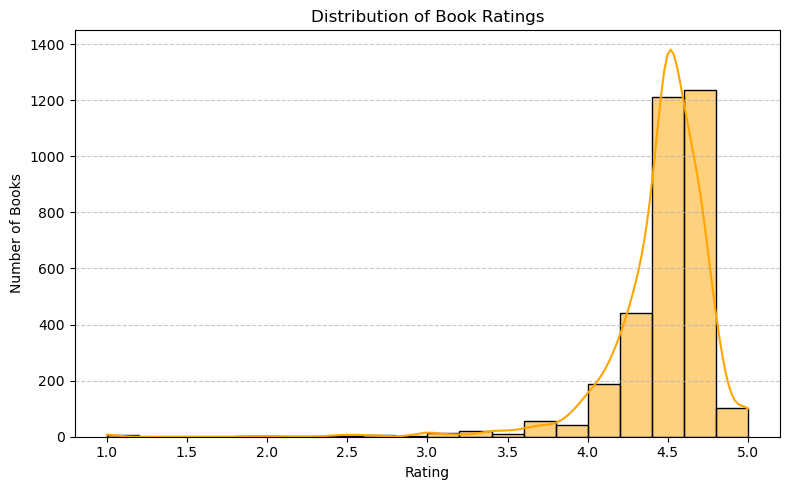

In [371]:
# Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='orange')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Books')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

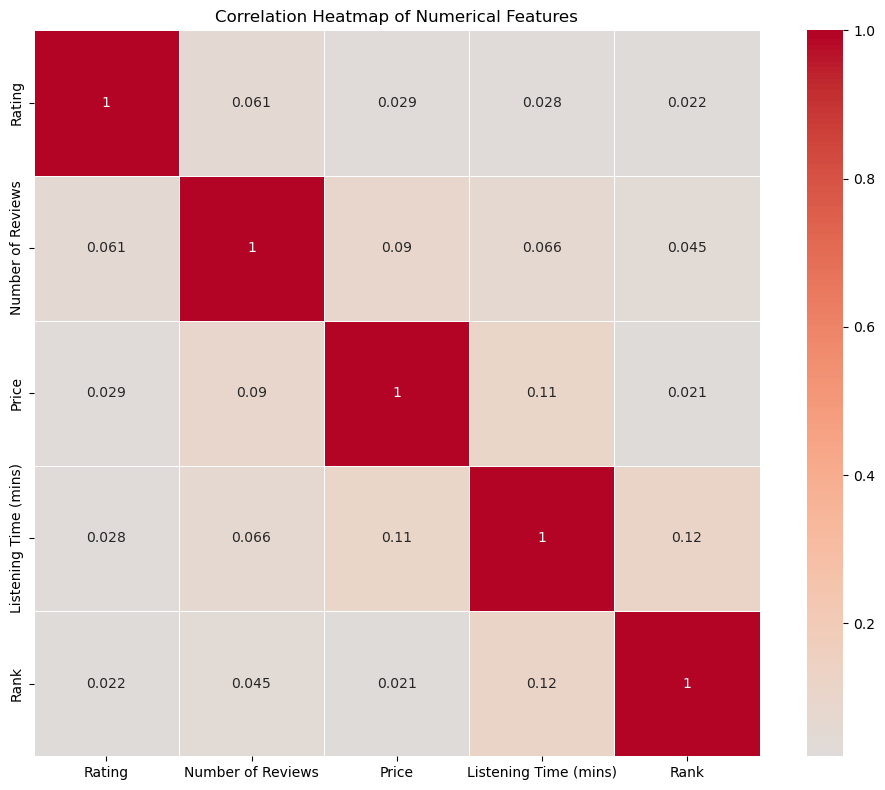

In [373]:
# 3. Correlation heatmap
plt.figure(figsize=(10, 8))
numerical_cols = ['Rating', 'Number of Reviews', 'Price', 'Listening Time (mins)', 'Rank']
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

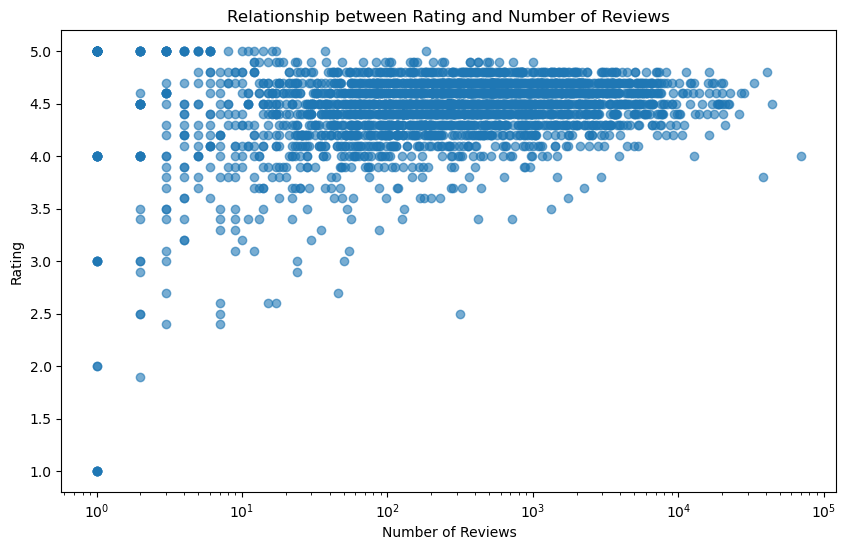

In [375]:
# 4. Rating vs Number of Reviews
plt.figure(figsize=(10, 6))
plt.scatter(df['Number of Reviews'], df['Rating'], alpha=0.6)
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.title('Relationship between Rating and Number of Reviews')
plt.xscale('log')
plt.show()

In [377]:
#Top Authors by Average Rating
# Filter authors with at least 10 books
author_stats = df.groupby('Author').agg({'Rating': ['mean', 'count']})
author_stats.columns = ['Avg Rating', 'Book Count']
top_authors = author_stats[author_stats['Book Count'] >= 10].sort_values('Avg Rating', ascending=False).head(10)

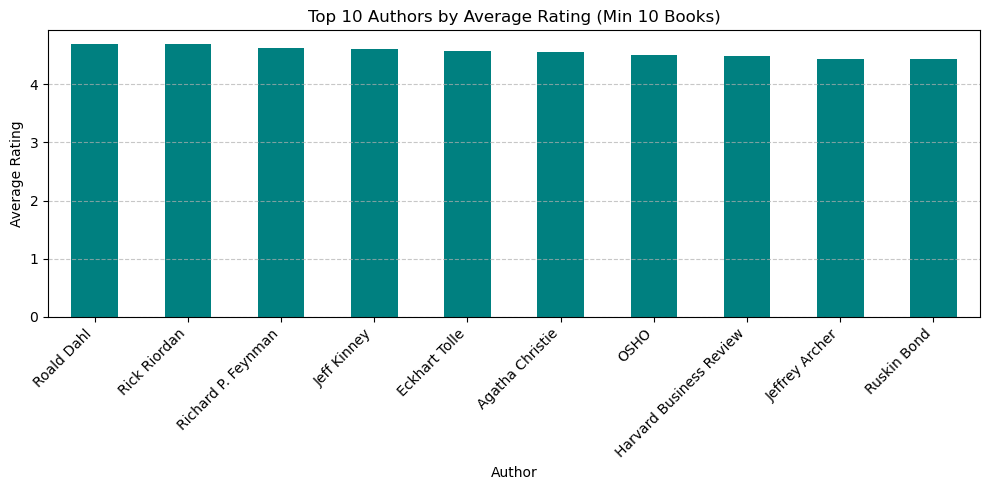

In [379]:
top_authors['Avg Rating'].plot(kind='bar', figsize=(10, 5), color='teal')
plt.title('Top 10 Authors by Average Rating (Min 10 Books)')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [381]:
# Filter books with at least 20 reviews
df_top_books = df[df['Number of Reviews'] >= 20]

In [383]:
# Sort by rating and number of reviews
top_books = df_top_books.sort_values(by=['Rating', 'Number of Reviews'], ascending=[False, False]).head(10)

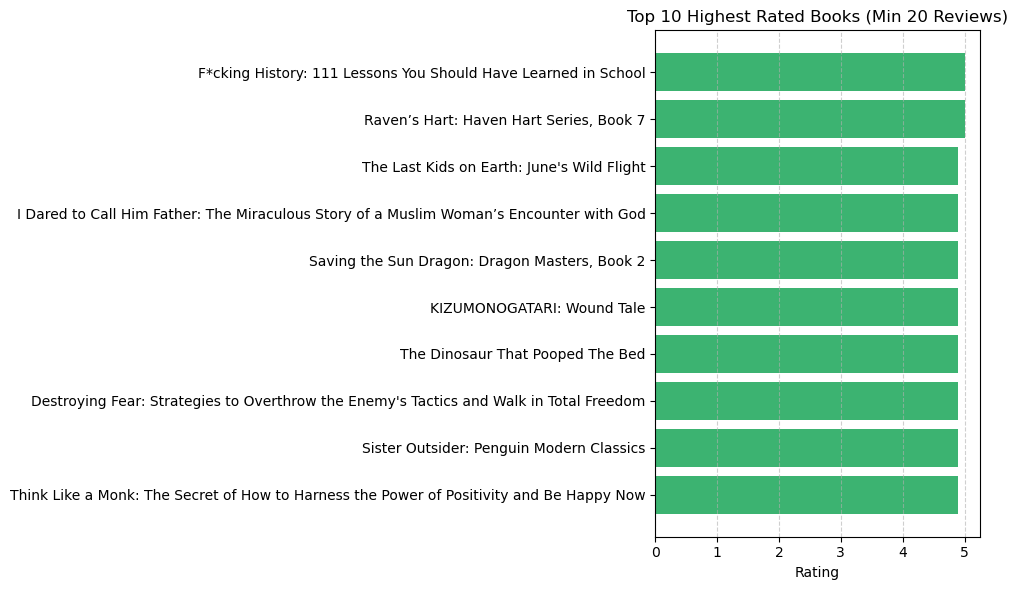

                                              Book Name          Author  \
165   F*cking History: 111 Lessons You Should Have L...     The Captain   
2551            Raven’s Hart: Haven Hart Series, Book 7   Davidson King   
2396         The Last Kids on Earth: June's Wild Flight    Max Brallier   
1893  I Dared to Call Him Father: The Miraculous Sto...  Bilquis Sheikh   
1406      Saving the Sun Dragon: Dragon Masters, Book 2     Tracey West   
2501                         KIZUMONOGATARI: Wound Tale       NISIOISIN   
2419                   The Dinosaur That Pooped The Bed  Dougie Poynter   
3299  Destroying Fear: Strategies to Overthrow the E...    John Ramirez   
2487           Sister Outsider: Penguin Modern Classics     Audre Lorde   
0     Think Like a Monk: The Secret of How to Harnes...      Jay Shetty   

      Rating  Number of Reviews  
165      5.0                185  
2551     5.0                 37  
2396     4.9               1009  
1893     4.9                736  
1406

In [385]:
plt.figure(figsize=(10, 6))
plt.barh(top_books['Book Name'], top_books['Rating'], color='mediumseagreen')
plt.xlabel('Rating')
plt.title('Top 10 Highest Rated Books (Min 20 Reviews)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Show book details
print(top_books[['Book Name', 'Author', 'Rating', 'Number of Reviews']])

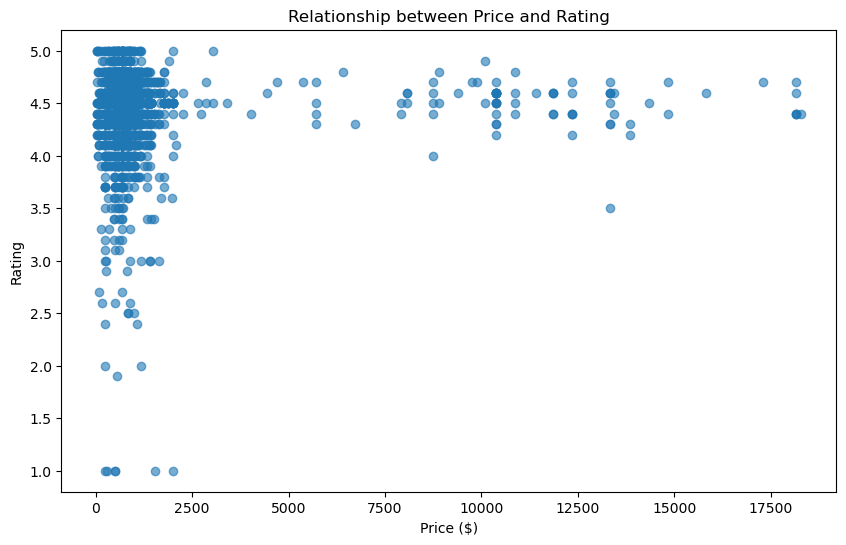

In [387]:
# 6. Price vs Rating analysis
paid_books = df[df['Price'] > 0]
plt.figure(figsize=(10, 6))
plt.scatter(paid_books['Price'], paid_books['Rating'], alpha=0.6)
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.title('Relationship between Price and Rating')
plt.show()

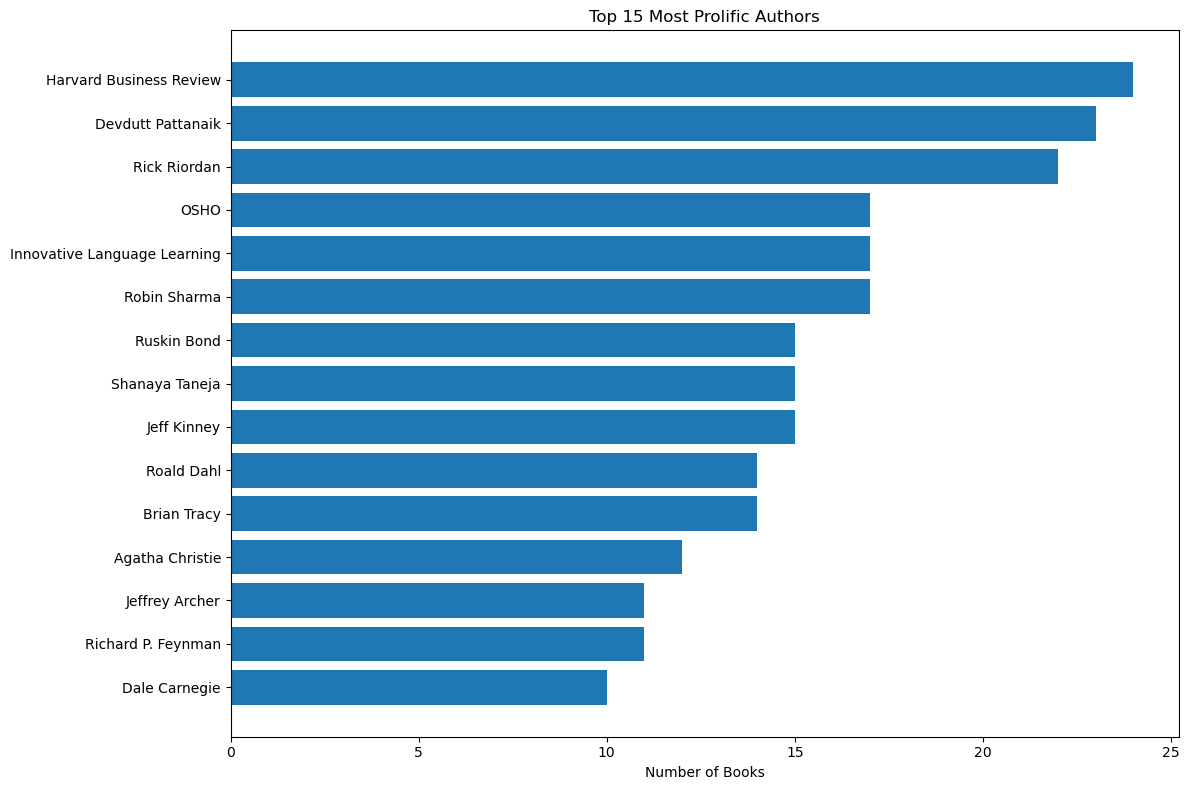

In [389]:
# Top authors bar chart
plt.figure(figsize=(12, 8))
top_authors = df['Author'].value_counts().head(15)
plt.barh(range(len(top_authors)), top_authors.values)
plt.yticks(range(len(top_authors)), top_authors.index)
plt.xlabel('Number of Books')
plt.title('Top 15 Most Prolific Authors')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [391]:
df.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (mins),Rank,Genre,Review_Category,Author_Book_Count
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371,10080,"Over the past three years, Jay Shetty has beco...",654.0,1,Society & Culture,Medium (101-1000),2
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682,615,Brought to you by Penguin.,203.0,2,Personal Success,High (1001-5000),2
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306,10378,"In this generation-defining self-help guide, a...",317.0,3,Personal Development & Self-Help,Very High (5000+),4
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678,888,Brought to you by Penguin.,335.0,5,Personal Success,High (1001-5000),1
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308,1005,"Stop going through life, Start growing throug...",385.0,6,Spiritualism,High (1001-5000),1


In [393]:
# Drop unwanted column
df.drop(columns=["Review_Category"], inplace=True)
df.drop(columns=["Author_Book_Count"], inplace=True)

In [395]:
df.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (mins),Rank,Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371,10080,"Over the past three years, Jay Shetty has beco...",654.0,1,Society & Culture
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682,615,Brought to you by Penguin.,203.0,2,Personal Success
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306,10378,"In this generation-defining self-help guide, a...",317.0,3,Personal Development & Self-Help
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678,888,Brought to you by Penguin.,335.0,5,Personal Success
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308,1005,"Stop going through life, Start growing throug...",385.0,6,Spiritualism


## NLP and Clustering

In [3]:
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [5]:
# Load data
df = pd.read_csv('cleaned_book_data.csv')

In [7]:
# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

In [11]:
# Combine and clean text
df['combined_text'] = df['Book Name'].fillna('') + ' ' + df['Description'].fillna('')
df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

In [13]:
# TF-IDF with n-grams and min_df
tfidf = TfidfVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2
)
X_text = tfidf.fit_transform(df['cleaned_text'])

In [15]:
# One-hot encode Genre
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_encoded = encoder.fit_transform(df[['Genre']].fillna('Unknown'))

In [17]:
# Log-transform and scale numerical features
num_features = df[['Rating', 'Number of Reviews', 'Price', 'Listening Time (mins)', 'Rank']].copy()
num_features['Number of Reviews'] = np.log1p(num_features['Number of Reviews'])
num_features['Price'] = np.log1p(num_features['Price'])
scaler = MinMaxScaler()
structured_scaled = scaler.fit_transform(num_features)

In [19]:
# Combine features
from scipy.sparse import hstack
X_combined = hstack([X_text, structured_scaled, genre_encoded])

In [25]:
# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=30, random_state=42)
X_umap = reducer.fit_transform(X_combined)

C:\Users\DELL\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [27]:
# KMeans Clustering
best_k = None
best_score = -1
silhouette_scores = {}
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++')
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_kmeans_model = kmeans

In [29]:
df['KMeans_Cluster'] = best_labels

In [31]:
# KMeans Evaluation
kmeans_sil = silhouette_score(X_umap, df['KMeans_Cluster'])
kmeans_ch = calinski_harabasz_score(X_umap, df['KMeans_Cluster'])
kmeans_db = davies_bouldin_score(X_umap, df['KMeans_Cluster'])

In [33]:
print("\n✅ KMeans Scores:")
print(f"Best k: {best_k}")
print(f"Silhouette Score: {kmeans_sil:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.2f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")


✅ KMeans Scores:
Best k: 3
Silhouette Score: 0.6908
Calinski-Harabasz Score: 7453.39
Davies-Bouldin Index: 0.3564


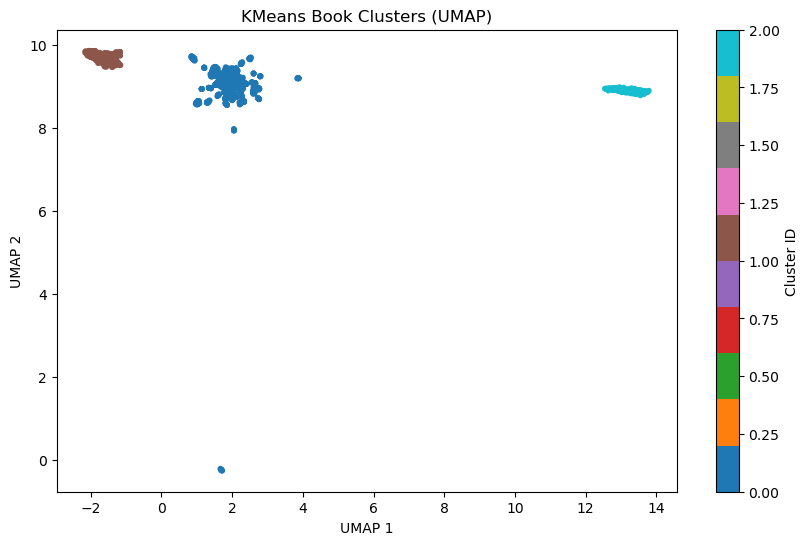

In [35]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['KMeans_Cluster'], cmap='tab10', s=10)
plt.title('KMeans Book Clusters (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [37]:
# For KMeans
for c in sorted(df['KMeans_Cluster'].unique()):
    print(f"\nKMeans Cluster {c}:")
    print(df[df['KMeans_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))


KMeans Cluster 0:
                                           Book Name  \
0  Think Like a Monk: The Secret of How to Harnes...   
1  Ikigai: The Japanese Secret to a Long and Happ...   
2  The Subtle Art of Not Giving a F*ck: A Counter...   
3  Atomic Habits: An Easy and Proven Way to Build...   
4  Life's Amazing Secrets: How to Find Balance an...   

                              Genre  Rating  
0                 Society & Culture     4.9  
1                  Personal Success     4.6  
2  Personal Development & Self-Help     4.4  
3                  Personal Success     4.6  
4                      Spiritualism     4.6  

KMeans Cluster 1:
                                            Book Name  \
30                                            My Gita   
50  Men Are from Mars, Women Are from Venus: The C...   
52                                        Hit Refresh   
55  A Game of Thrones: Book 1 of A Song of Ice and...   
56  The 10X Rule: The Only Difference Between Succ...   

      

In [39]:
# --- DBSCAN Clustering ---
best_dbscan_score = -1
best_dbscan_eps = None
best_dbscan_labels = None
best_dbscan_model = None

In [41]:
for eps in np.arange(0.2, 1.0, 0.05):
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(X_umap)
    # Ignore runs where all points are noise or only 1 cluster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        continue
    mask = labels != -1
    if np.sum(mask) == 0:
        continue
    score = silhouette_score(X_umap[mask], labels[mask])
    print(f"DBSCAN eps={eps:.2f} ➤ clusters={n_clusters}, silhouette={score:.4f}")
    if score > best_dbscan_score:
        best_dbscan_score = score
        best_dbscan_eps = eps
        best_dbscan_labels = labels
        best_dbscan_model = dbscan

DBSCAN eps=0.20 ➤ clusters=117, silhouette=0.5838
DBSCAN eps=0.25 ➤ clusters=112, silhouette=0.5447
DBSCAN eps=0.30 ➤ clusters=114, silhouette=0.5441
DBSCAN eps=0.35 ➤ clusters=106, silhouette=0.6374
DBSCAN eps=0.40 ➤ clusters=103, silhouette=0.6262
DBSCAN eps=0.45 ➤ clusters=93, silhouette=0.5897
DBSCAN eps=0.50 ➤ clusters=88, silhouette=0.7318
DBSCAN eps=0.55 ➤ clusters=84, silhouette=0.7244
DBSCAN eps=0.60 ➤ clusters=80, silhouette=0.7188
DBSCAN eps=0.65 ➤ clusters=76, silhouette=0.7108
DBSCAN eps=0.70 ➤ clusters=74, silhouette=0.7096
DBSCAN eps=0.75 ➤ clusters=72, silhouette=0.7076
DBSCAN eps=0.80 ➤ clusters=71, silhouette=0.7059
DBSCAN eps=0.85 ➤ clusters=69, silhouette=0.7184
DBSCAN eps=0.90 ➤ clusters=67, silhouette=0.7000
DBSCAN eps=0.95 ➤ clusters=65, silhouette=0.7002


In [43]:
df['DBSCAN_Cluster'] = best_dbscan_labels


✅ Best DBSCAN Scores:
Best eps: 0.50
Silhouette Score: 0.7318
Calinski-Harabasz Score: 3660.48
Davies-Bouldin Index: 0.4705


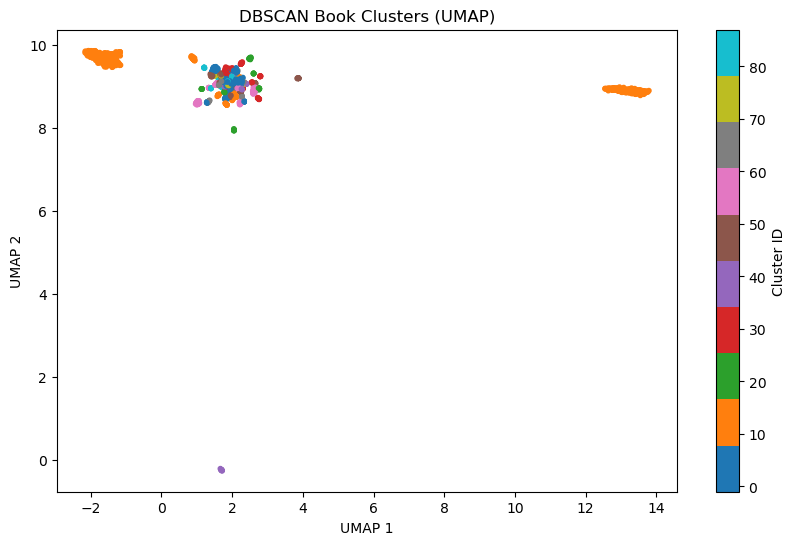

In [45]:
# DBSCAN Evaluation
if best_dbscan_labels is not None:
    mask = best_dbscan_labels != -1
    dbscan_sil = silhouette_score(X_umap[mask], best_dbscan_labels[mask])
    dbscan_ch = calinski_harabasz_score(X_umap[mask], best_dbscan_labels[mask])
    dbscan_db = davies_bouldin_score(X_umap[mask], best_dbscan_labels[mask])
    print("\n✅ Best DBSCAN Scores:")
    print(f"Best eps: {best_dbscan_eps:.2f}")
    print(f"Silhouette Score: {dbscan_sil:.4f}")
    print(f"Calinski-Harabasz Score: {dbscan_ch:.2f}")
    print(f"Davies-Bouldin Index: {dbscan_db:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['DBSCAN_Cluster'], cmap='tab10', s=10)
    plt.title('DBSCAN Book Clusters (UMAP)')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar(label='Cluster ID')
    plt.show()

In [47]:
# For DBSCAN (ignore noise points, i.e., -1)
for c in sorted(df['DBSCAN_Cluster'].unique()):
    if c == -1: continue  # Skip noise
    print(f"\nDBSCAN Cluster {c}:")
    print(df[df['DBSCAN_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))


DBSCAN Cluster 0:
                                              Book Name              Genre  \
0     Think Like a Monk: The Secret of How to Harnes...  Society & Culture   
737            The Law Book: Big Ideas Simply Explained  Society & Culture   
1032  Gender Trouble: Feminism and the Subversion of...  Society & Culture   
1205              A Room of One's Own: Penguin Classics  Society & Culture   
1230         The Seven Basic Plots: Why We Tell Stories  Society & Culture   

      Rating  
0        4.9  
737      5.0  
1032     4.4  
1205     4.4  
1230     4.3  

DBSCAN Cluster 1:
                                            Book Name             Genre  \
1   Ikigai: The Japanese Secret to a Long and Happ...  Personal Success   
3   Atomic Habits: An Easy and Proven Way to Build...  Personal Success   
15                            Thinking, Fast and Slow  Personal Success   
27  The Power of Habit: Why We Do What We Do, and ...  Personal Success   
38  Limitless: Upgrade Your 

In [53]:
# --- HDBSCAN CLUSTERING ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,           # Try 3–10 for small datasets
    min_samples=5,                # Try 3–10 for small datasets
    metric='euclidean',           # You can also try 'manhattan' or 'cosine'
    cluster_selection_method='eom',
    prediction_data=True
)
hdb_labels = clusterer.fit_predict(X_umap)
df['HDBSCAN_Cluster'] = hdb_labels

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [55]:
# --- EVALUATION ---
mask = hdb_labels != -1
n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
if n_clusters > 1 and np.sum(mask) > 0:
    hdb_sil = silhouette_score(X_umap[mask], hdb_labels[mask])
    hdb_ch = calinski_harabasz_score(X_umap[mask], hdb_labels[mask])
    hdb_db = davies_bouldin_score(X_umap[mask], hdb_labels[mask])
    print("\n✅ HDBSCAN Scores:")
    print(f"Clusters found: {n_clusters}")
    print(f"Silhouette Score: {hdb_sil:.4f}")
    print(f"Calinski-Harabasz Score: {hdb_ch:.2f}")
    print(f"Davies-Bouldin Index: {hdb_db:.4f}")
else:
    print("HDBSCAN found less than 2 clusters or all noise.")


✅ HDBSCAN Scores:
Clusters found: 102
Silhouette Score: 0.8734
Calinski-Harabasz Score: 5571.58
Davies-Bouldin Index: 0.2514


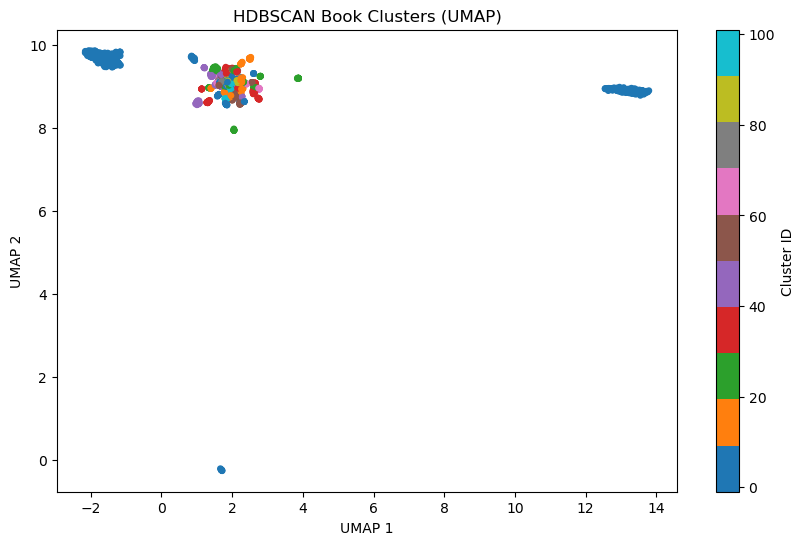

In [57]:
# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='tab10', s=15)
plt.title('HDBSCAN Book Clusters (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [61]:
# Show size and example books per cluster
cluster_counts = df['HDBSCAN_Cluster'].value_counts().sort_values(ascending=False)
print(cluster_counts)

# Example: Show top 5 books from 3 largest clusters
for c in cluster_counts.index[:3]:
    print(f"\nCluster {c} (size={cluster_counts[c]}):")
    print(df[df['HDBSCAN_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))

HDBSCAN_Cluster
 2     757
 0     445
-1     266
 10    159
 38    112
      ... 
 74      6
 63      6
 46      6
 93      6
 79      6
Name: count, Length: 103, dtype: int64

Cluster 2 (size=757):
                                            Book Name  \
30                                            My Gita   
50  Men Are from Mars, Women Are from Venus: The C...   
52                                        Hit Refresh   
55  A Game of Thrones: Book 1 of A Song of Ice and...   
56  The 10X Rule: The Only Difference Between Succ...   

                                Genre  Rating  
30  Theology & Philosophy of Religion     4.2  
50  Theology & Philosophy of Religion     4.5  
52  Theology & Philosophy of Religion     4.4  
55  Theology & Philosophy of Religion     4.7  
56  Theology & Philosophy of Religion     4.6  

Cluster 0 (size=445):
                                            Book Name    Genre  Rating
12                                        The Sandman  Fantasy     5.0
26   

In [63]:
# --- Save Models and Results ---
with open('tfidf_vectorizer_improved.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('kmeans_model_improved.pkl', 'wb') as f:
    pickle.dump(best_kmeans_model, f)
with open('dbscan_model_best.pkl', 'wb') as f:
    pickle.dump(best_dbscan_model, f)
with open('hdbscan_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)
with open('umap_model.pkl', 'wb') as f:
    pickle.dump(reducer, f)

In [65]:
df.to_csv('clustered_books_improved.csv', index=False)

## Content-Based Recommendation

In [67]:
df = pd.read_csv('clustered_books_improved.csv')

In [69]:
# Fill NaNs in cleaned_text if needed
df['cleaned_text'] = df['cleaned_text'].fillna('')

In [71]:
def build_content_model(df):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim, tfidf

## Clustering & Hybrid Based recommendation

In [75]:
def recommend_content(title, df, cosine_sim, top_n=5):
    indices = pd.Series(df.index, index=df['Book Name']).drop_duplicates()
    idx = indices.get(title)
    if idx is None:
        return []
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    book_indices = [i[0] for i in sim_scores]
    return df['Book Name'].iloc[book_indices].tolist()

def recommend_by_cluster(title, df, cluster_col='KMeans_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def recommend_by_cluster_dbscan(title, df, cluster_col='DBSCAN_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def recommend_by_cluster_hdbscan(title, df, cluster_col='HDBSCAN_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def hybrid_recommend(title, df, cosine_sim, cluster_col='KMeans_Cluster', top_n=5):
    content_recs = set(recommend_content(title, df, cosine_sim, top_n*2))
    cluster_recs = set(recommend_by_cluster(title, df, cluster_col, top_n*2))
    hybrid = list(content_recs & cluster_recs)
    if len(hybrid) < top_n:
        hybrid = list(content_recs | cluster_recs)
    return hybrid[:top_n]

### EVALUATION METRICS

In [77]:
def evaluate_recommendation(df, rec_func, cosine_sim=None, cluster_col='KMeans_Cluster', top_n=5):
    y_true, y_pred = [], []
    for idx, row in df.iterrows():
        true_cluster = int(row[cluster_col])
        if rec_func == recommend_content:
            recs = rec_func(row['Book Name'], df, cosine_sim, top_n=top_n)
        elif rec_func == hybrid_recommend:
            recs = rec_func(row['Book Name'], df, cosine_sim, cluster_col=cluster_col, top_n=top_n)
        else:
            recs = rec_func(row['Book Name'], df, cluster_col=cluster_col, top_n=top_n)
        pred_clusters = df[df['Book Name'].isin(recs)][cluster_col].values
        for pc in pred_clusters:
            y_true.append(true_cluster)
            y_pred.append(pc)
    return {
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Accuracy': accuracy_score(y_true, y_pred)
    }

In [79]:
if __name__ == "__main__":
    cosine_sim, tfidf = build_content_model(df)
    results = []

    # Content-based (using KMeans for evaluation)
    content_metrics = evaluate_recommendation(df, recommend_content, cosine_sim, cluster_col='KMeans_Cluster')
    # KMeans cluster-based
    kmeans_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='KMeans_Cluster')
    # DBSCAN cluster-based
    dbscan_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='DBSCAN_Cluster')
    # HDBSCAN cluster-based
    hdbscan_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='HDBSCAN_Cluster')
    # Hybrid (content + KMeans)
    hybrid_metrics_kmeans = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='KMeans_Cluster')
    # Hybrid (content + DBSCAN)
    hybrid_metrics_dbscan = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='DBSCAN_Cluster')
    # Hybrid (content + HDBSCAN)
    hybrid_metrics_hdbscan = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='HDBSCAN_Cluster')

    results.append({'Method': 'Content-Based', **content_metrics})
    results.append({'Method': 'KMeans Cluster-Based', **kmeans_metrics})
    results.append({'Method': 'DBSCAN Cluster-Based', **dbscan_metrics})
    results.append({'Method': 'HDBSCAN Cluster-Based', **hdbscan_metrics})
    results.append({'Method': 'Hybrid (Content+KMeans)', **hybrid_metrics_kmeans})
    results.append({'Method': 'Hybrid (Content+DBSCAN)', **hybrid_metrics_dbscan})
    results.append({'Method': 'Hybrid (Content+HDBSCAN)', **hybrid_metrics_hdbscan})

    summary_df = pd.DataFrame(results)
    print("\n=== Recommendation Evaluation Summary ===")
    print(summary_df.round(4))
    summary_df.to_csv("recommendation_evaluation_summary.csv", index=False)


=== Recommendation Evaluation Summary ===
                     Method  Precision  Recall  F1-Score  Accuracy
0             Content-Based     0.8119  0.9120    0.8441    0.8507
1      KMeans Cluster-Based     0.9996  0.9998    0.9997    0.9997
2      DBSCAN Cluster-Based     0.9957  0.9924    0.9937    0.9982
3     HDBSCAN Cluster-Based     0.9883  0.9839    0.9858    0.9955
4   Hybrid (Content+KMeans)     0.8706  0.9464    0.9007    0.9082
5   Hybrid (Content+DBSCAN)     0.5739  0.4694    0.4958    0.6822
6  Hybrid (Content+HDBSCAN)     0.5576  0.4784    0.4952    0.6625


In [85]:
    sample_title = "Think Like a Monk: The Secret of How to Harness the Power of Positivity and Be Happy Now"
    print("\n🔍 Sample Recommendations (Content-Based):")
    print(recommend_content(sample_title, df, cosine_sim))

    print("\n🔍 Sample Recommendations (KMeans Cluster-Based):")
    print(recommend_by_cluster(sample_title, df, cluster_col='KMeans_Cluster'))

    print("\n🔍 Sample Recommendations (DBSCAN Cluster-Based):")
    print(recommend_by_cluster(sample_title, df, cluster_col='DBSCAN_Cluster'))

    print("\n🔍 Sample Recommendations (HDBSCAN Cluster-Based):")
    print(recommend_by_cluster(sample_title, df, cluster_col='HDBSCAN_Cluster'))

    print("\n🔍 Sample Recommendations (Hybrid, KMeans):")
    print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='KMeans_Cluster'))

    print("\n🔍 Sample Recommendations (Hybrid, DBSCAN):")
    print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='DBSCAN_Cluster'))

    print("\n🔍 Sample Recommendations (Hybrid, HDBSCAN):")
    print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='HDBSCAN_Cluster'))

    # SAVE MODELS
    with open('cosine_sim_new.pkl', 'wb') as f:
        pickle.dump(cosine_sim, f)
    with open('tfidf_new.pkl', 'wb') as f:
        pickle.dump(tfidf, f)
    with open('kmeans_model_n.pkl', 'wb') as f:
        pickle.dump(kmeans, f)
    with open('dbscan_model_n.pkl', 'wb') as f:
        pickle.dump(dbscan, f)
    with open('hdbscan_model_n.pkl', 'wb') as f:
        pickle.dump(clusterer, f)

    print("\n✅ Models and evaluation summary saved.")


🔍 Sample Recommendations (Content-Based):
['The Classic Tales Podcast, Season Five', 'The Facebook Effect: The Inside Story of the Company That Is Connecting the World', "One Million Followers: How I Built a Massive Social Following in 30 Days: Growth Hacks for Your Business, Your Message, and Your Brand from the World's Greatest Minds", 'Social Media Marketing Workbook 2020', 'The Simulation Hypothesis: An MIT Computer Scientist Shows Why AI, Quantum Physics, and Eastern Mystics All Agree We Are in a Video Game']

🔍 Sample Recommendations (KMeans Cluster-Based):
['Ikigai: The Japanese Secret to a Long and Happy Life', 'The Subtle Art of Not Giving a F*ck: A Counterintuitive Approach to Living a Good Life', 'Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones', "Life's Amazing Secrets: How to Find Balance and Purpose in Your Life", 'Extraordinary Leadership']

🔍 Sample Recommendations (DBSCAN Cluster-Based):
['The Law Book: Big Ideas Simply Explained', 'Gende